In [ ]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#declare sampling rate
sampling_rate = 16000
#get the audio path of all the audios
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [ ]:
#Read the data and get the shapes of the dataframe
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')

#lets only keep audio files > 8 sec
bird_df = bird_df[bird_df['duration_secs_32000'] >= 8]
print(bird_df.shape)

bird_df.head(2)

(794, 9)


,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train


In [ ]:
# Assuming you have your dataframe loaded into the variable "df"
bird_df = pd.get_dummies(bird_df, columns=['continent'], prefix='continent')
bird_df.head(2)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,data,continent_AFRICA,continent_AMERICAS,continent_ASIA,continent_EUROPE,continent_UNKNOWN
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,train,0,0,0,1,0
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,train,0,0,0,1,0


In [ ]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
print("train data:",bird_train_df.shape)

#Gather the separate validation set from the csv
bird_val_df =  bird_df[bird_df['data'] == 'val']
print("validation data:",bird_val_df.shape)

train data: (560, 13)
validation data: (234, 13)


In [ ]:
bird_train_df.head(1)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,data,continent_AFRICA,continent_AMERICAS,continent_ASIA,continent_EUROPE,continent_UNKNOWN
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,train,0,0,0,1,0


In [ ]:
#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 8.0,
      hop_size_s: float = 4.0,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=False)
    return framed_audio

In [ ]:
def extract_mfcc_and_spectral_centroid_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20, n_chroma=12):
    mfcc_frames = []
    spectral_centroid_frames = []
    target_label = []

    for frame in framed_audio:
        frame = np.array(frame)

        # Extract MFCC from the main audio frame
        mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)
        transposed_mfcc = mfcc.T

        # Extract spectral centroid from the main audio frame
        spectral_centroid = librosa.feature.spectral_centroid(y=frame, sr=sample_rate)
        transposed_spectral_centroid = spectral_centroid.T

        # Append the features to the respective lists
        mfcc_frames.append(transposed_mfcc)
        spectral_centroid_frames.append(transposed_spectral_centroid)
        target_label.append(class_label)

    # Combine MFCC and spectral centroid features along the time axis
    combined_frames = [np.hstack((mfcc, spectral_centroid)) for mfcc, spectral_centroid in zip(mfcc_frames, spectral_centroid_frames)]
    combined_frames = np.array(combined_frames)

    # Convert the lists to numpy arrays
    target_label = np.array(target_label)

    return combined_frames, target_label

In [ ]:
def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']

        #For audios with duration >= 8 seconds, proceed as before
        audio = load_audio(file_name)  # Load the audio using the load_audio function
        framed_audio = frame_audio(audio)  # Frame the audio into 8-second segments

        # Extract MFCC and spectral centroid features for each frame
        mfcc_frames, target_label = extract_mfcc_and_spectral_centroid_from_frames(framed_audio, class_label, sample_rate=sampling_rate)

        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels


In [ ]:
#encode the target variable
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [ ]:
#scale data
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [ ]:
#create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [ ]:
# Extract the mfcc embeddings from the model
train_embeddings, labels = extract_final_features_from_dataframe(bird_train_df)

In [ ]:
train_embeddings[:1]

[array([[-6.40857910e+02,  6.46771851e+01, -6.29885521e+01, ...,
         -1.08033371e+00, -1.50528407e+00,  1.98683053e+03],
        [-3.67023804e+02,  6.11631927e+01, -6.40725555e+01, ...,
         -1.08003788e+01, -6.31683826e+00,  2.06714511e+03],
        [-2.92503204e+02,  5.88846893e+01, -6.74059753e+01, ...,
         -7.55926609e+00, -2.87263107e+00,  2.07534286e+03],
        ...,
        [-2.91017456e+02,  6.15616760e+01, -5.74858971e+01, ...,
         -1.14104509e+00, -2.49208689e+00,  2.13842288e+03],
        [-2.91305878e+02,  5.37731171e+01, -5.42837334e+01, ...,
         -5.22096395e+00, -1.28884435e-01,  2.33472283e+03],
        [-3.29628143e+02,  4.81204491e+01, -4.91389999e+01, ...,
         -9.29372597e+00,  2.12649322e+00,  2.52854892e+03]])]

In [ ]:
#verify the shapes
x_train = np.array(train_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(4555, 251, 21)
(4555,)


In [ ]:
#extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [ ]:
#display a sample embedding from the validation dataset
val_embeddings[:1]

[array([[-3.40613800e+02,  1.27008263e+02,  4.42717743e+01, ...,
         -6.83337808e-01,  1.10607815e+01,  7.48194361e+02],
        [-2.83616699e+02,  1.24639816e+02,  3.80632324e+01, ...,
          5.67251980e-01,  6.37503433e+00,  8.75218688e+02],
        [-2.75975647e+02,  1.24306831e+02,  3.49290543e+01, ...,
          2.29616117e+00,  3.15063739e+00,  9.94964999e+02],
        ...,
        [-2.73981232e+02,  1.36268066e+02,  5.17533417e+01, ...,
          6.51623189e-01,  2.89341331e+00,  8.93063267e+02],
        [-2.67342560e+02,  1.30733444e+02,  4.79498978e+01, ...,
          1.71484911e+00,  4.02341795e+00,  9.79677857e+02],
        [-2.83436401e+02,  1.16292267e+02,  3.49498978e+01, ...,
         -4.25243855e+00,  2.17064023e-02,  1.20689067e+03]])]

In [ ]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(1785, 251, 21)
(1785,)


In [ ]:
#call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)
#verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(4555, 3)
(1785, 3)


In [ ]:
#scale the extracted embeddings
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)
print(x_train_scaled[:1])

[[[0.33978738 0.68793538 0.28209973 ... 0.51217256 0.38610621 0.26785829]
  [0.59280273 0.66793327 0.28650357 ... 0.43383001 0.35844648 0.280442  ]
  [0.67914246 0.64029561 0.33524839 ... 0.528568   0.42202951 0.28287074]
  ...
  [0.64161968 0.68365215 0.38953686 ... 0.58838139 0.50795896 0.28877641]
  [0.65400476 0.6328816  0.38573987 ... 0.50833723 0.53667046 0.3188964 ]
  [0.65841814 0.62336723 0.39894912 ... 0.45432782 0.58814107 0.33660049]]]


In [ ]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

(4555, 251, 21)
(4555, 3)
(1785, 251, 21)
(1785, 3)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

def train_gru_model(x_train, y_train, x_val, y_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100):
    input_shape = x_train.shape[1:]  # Shape of one sample in x_train

    inputs = Input(shape=input_shape, name='Input')
    gru_output = GRU(256)(inputs)
    dropout_1 = Dropout(0.2)(gru_output)
    dense_1 = Dense(256, activation='relu')(dropout_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dropout_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(48, activation='relu')(dropout_2)
    dropout_3 = Dropout(0.4)(dense_3)
    outputs = Dense(n_classes, activation='softmax', name='Output')(dropout_3)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define the early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return model, history

In [ ]:
#call the model
model, history = train_gru_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 251, 21)]         0         
                                                                 
 gru_1 (GRU)                 (None, 256)               214272    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 48)                6192

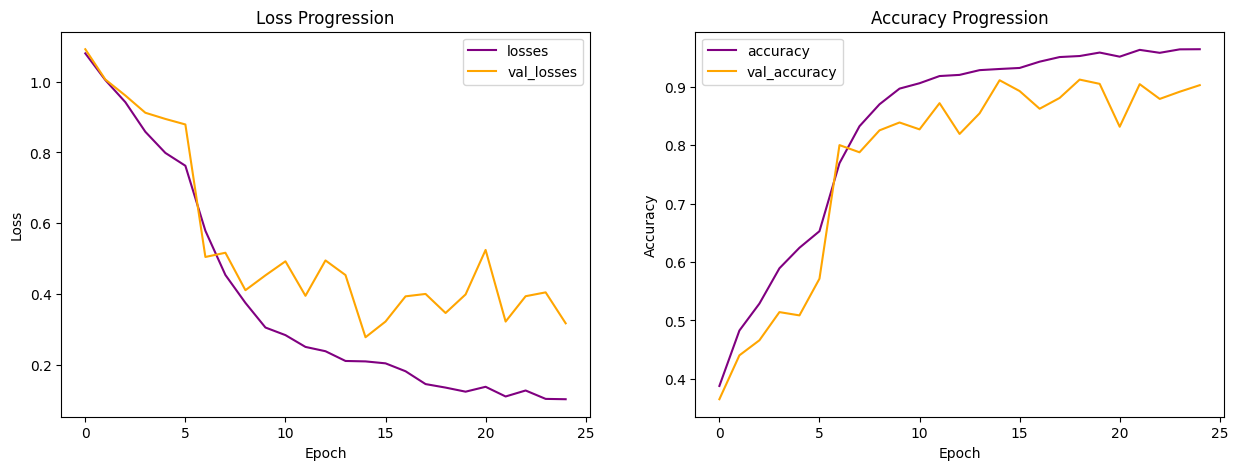

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Plot the training and validation accuracy and losses
    num_epochs = len(history.history['loss'])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axes[0].plot(range(num_epochs), history.history['loss'], color='purple', label='losses')
    axes[0].plot(range(num_epochs), history.history['val_loss'], color='orange', label='val_losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Progression')
    axes[0].legend()

    axes[1].plot(range(num_epochs), history.history['accuracy'], color='purple', label='accuracy')
    axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='orange', label='val_accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Progression')
    axes[1].legend()
    plt.show()

#call the plot function
plot_accuracy(history)

In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(history.model.predict(x_shuffled_train), axis=-1)
test_pred = np.argmax(history.model.predict(x_shuffled_val), axis=-1)
print(test_pred_train)
print(test_pred)

56/56 [==============================] - 12s 217ms/step
[2 2 0 ... 2 2 1]
[0 1 1 ... 0 1 1]


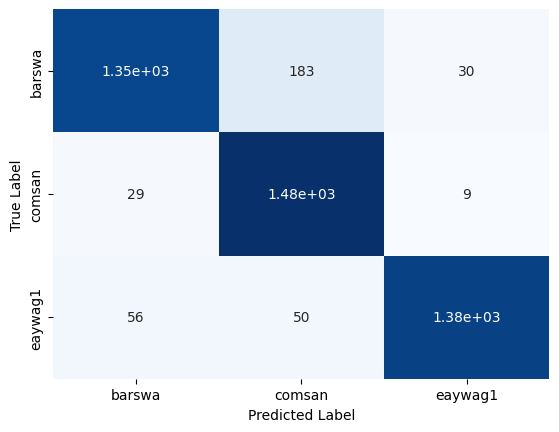

              precision    recall  f1-score   support

           0      0.941     0.864     0.900      1561
           1      0.864     0.975     0.916      1513
           2      0.972     0.928     0.950      1481

    accuracy                          0.922      4555
   macro avg      0.926     0.922     0.922      4555
weighted avg      0.925     0.922     0.922      4555



In [ ]:
#plot the  confusion matrix on the train dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

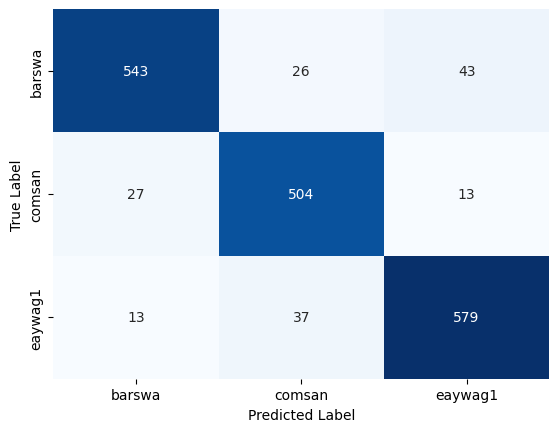

              precision    recall  f1-score   support

           0      0.931     0.887     0.909       612
           1      0.889     0.926     0.907       544
           2      0.912     0.921     0.916       629

    accuracy                          0.911      1785
   macro avg      0.911     0.911     0.911      1785
weighted avg      0.912     0.911     0.911      1785



In [ ]:
#plot the confusion matrix on the test dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

In [ ]:
model.save('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/RNN/1b.rnngru.model.h5')

In [ ]:
model.save('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/RNN/1b.rnngrubackup.model.h5')